In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
le = LabelEncoder()
data =pd.read_csv("heart.csv")
df=pd.read_csv("heart.csv")
df1 = data.copy(deep = True)
df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [32]:
russian_labels = {
    'Cholesterol': 'Уровень холестерина (мг/дл)',
    'ChestPainType': 'Тип боли в груди',
    'MaxHR': 'Макс. ЧСС (уд/мин)',
    'ST_Slope': 'Наклон сегмента ST',
    'Oldpeak': 'Депрессия сегмента ST при нагрузке',
    'ExerciseAngina': 'Стенокардия при физической нагрузке',
    'HeartDisease': 'Наличие сердечного заболевания',
    'Age': 'Возраст (годы)',
    'RestingBP': 'Артериальное давление в покое (мм рт. ст.)',
    'RestingECG': 'Показания ЭКГ в покое',
    'Sex': 'Пол',
    'FastingBS': 'Уровень сахара натощак',
}

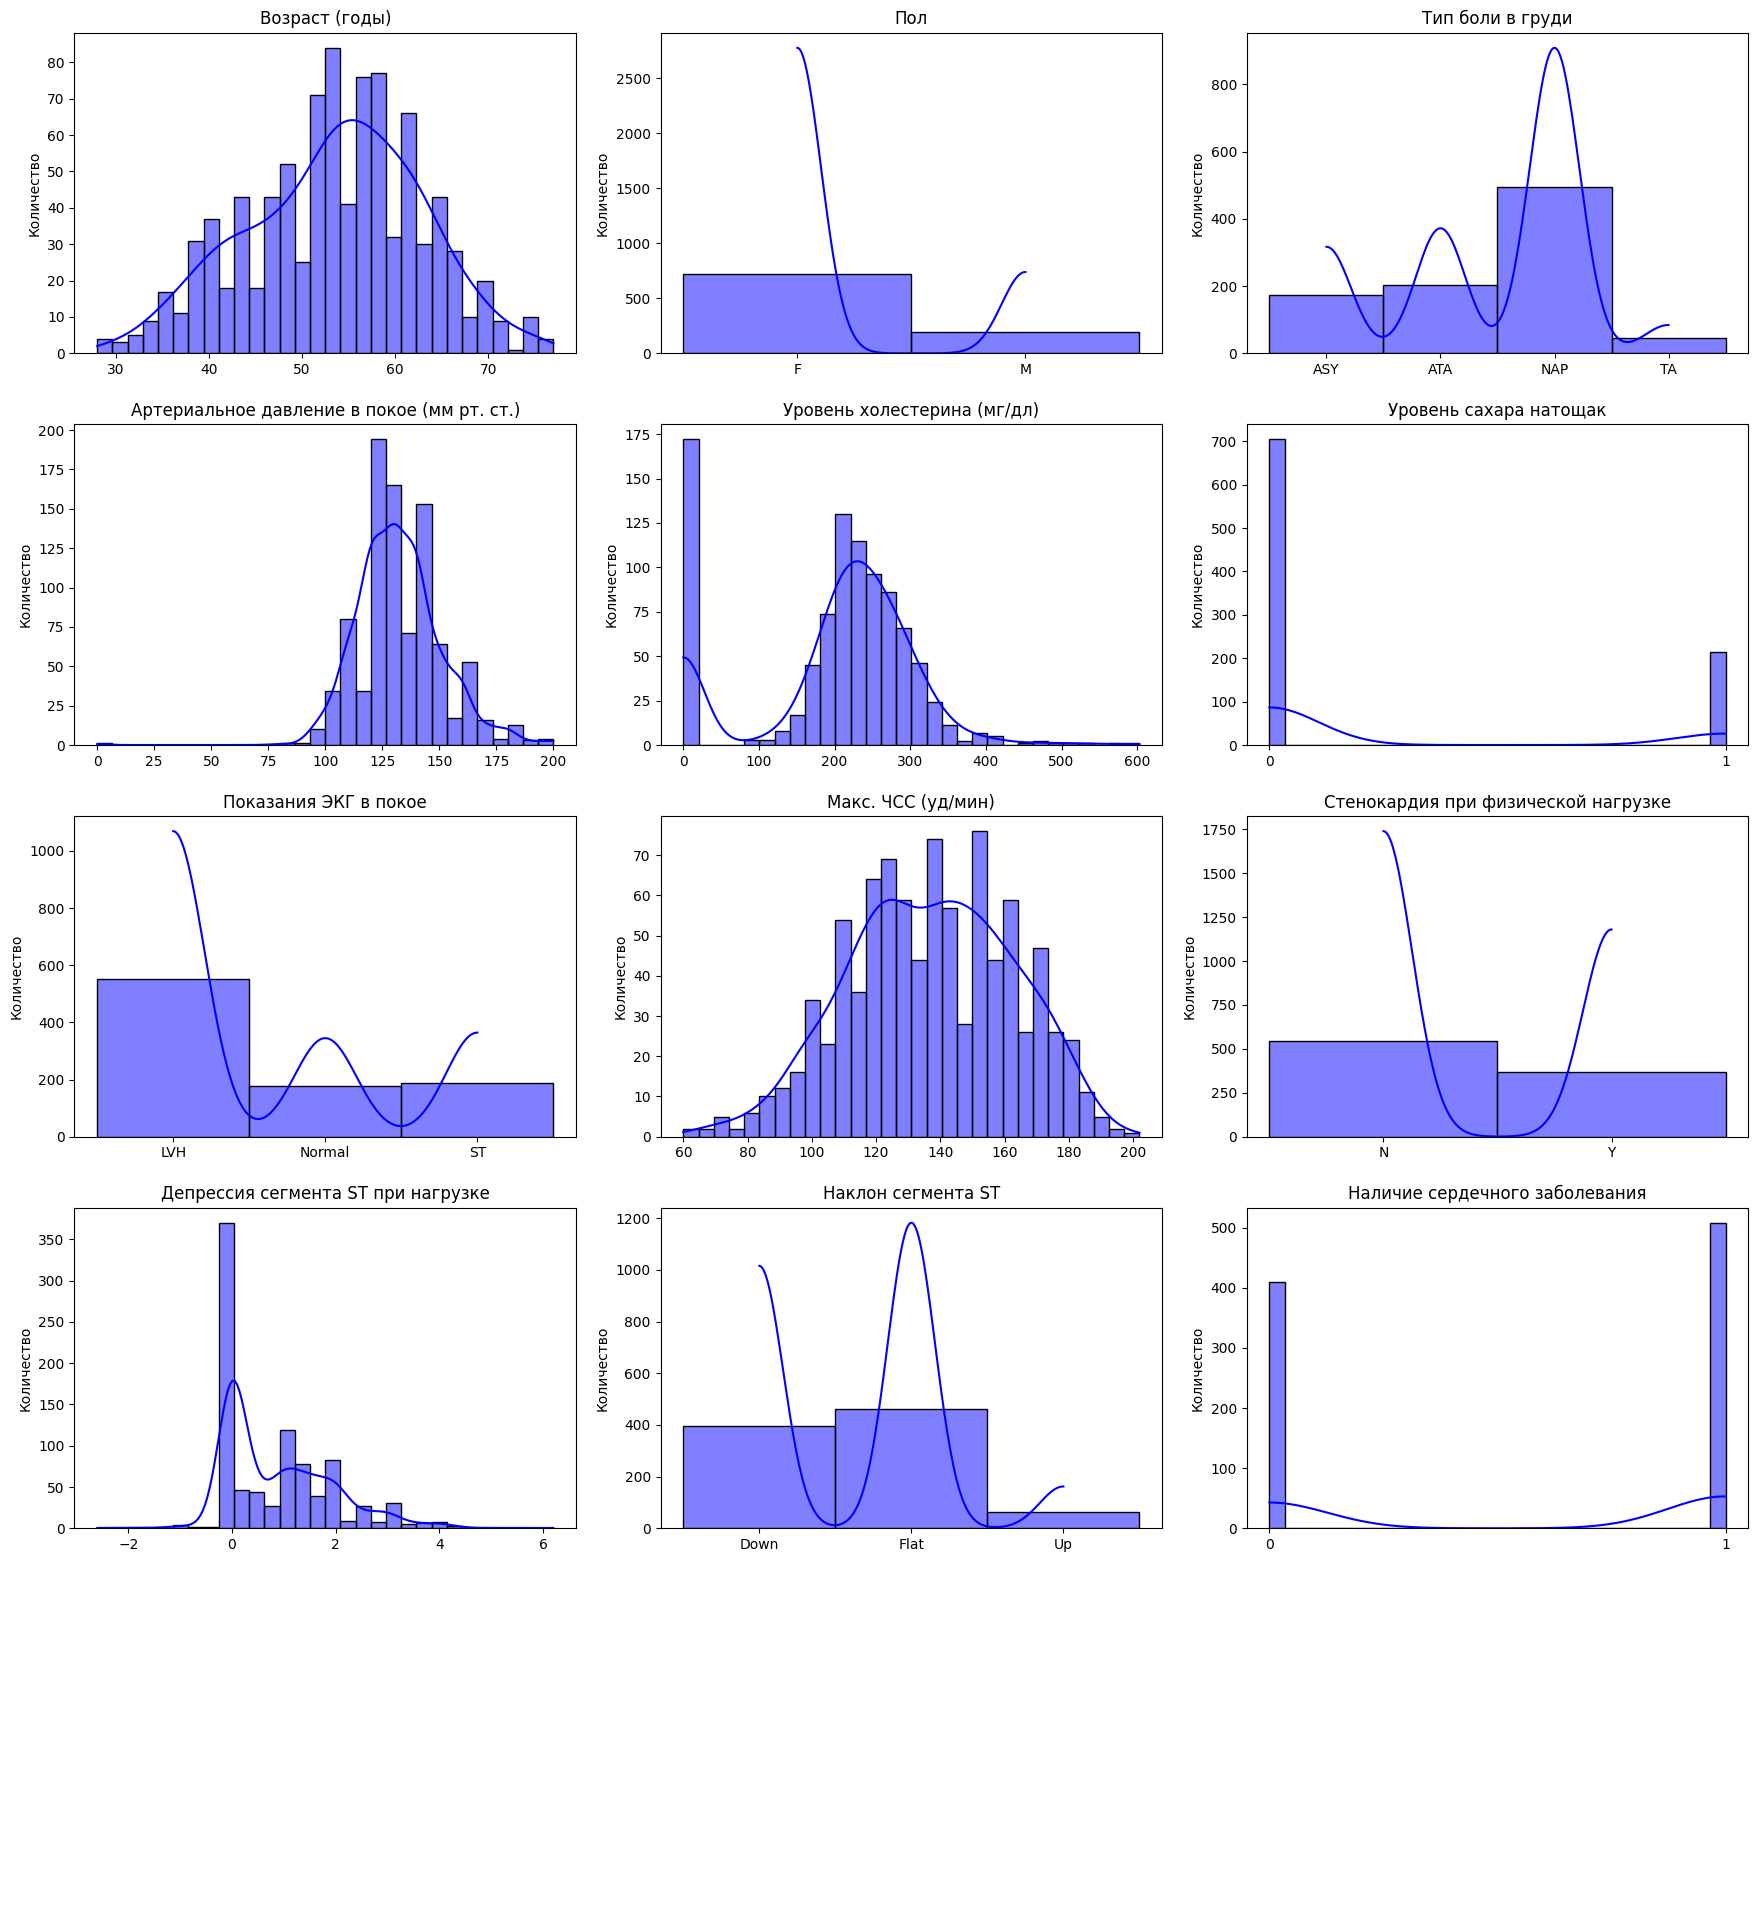

In [41]:
n_cols = 3
n_rows = (len(df.columns) // n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
fig.tight_layout(pad=3.0)
for i, col in enumerate(df.columns):
    ax = axes[i//n_cols, i%n_cols]
    sns.histplot(df[col], kde=True, bins=30, color='blue', ax=ax)
    ax.set_ylabel('Количество')
    ax.set_xlabel(' ')
    ax.set_title(russian_labels.get(col, col))
    if df[col].dtype == 'object' or df[col].nunique() < 5:
        ax.set_xticks(range(df[col].nunique()))
        ax.set_xticklabels([str(x) for x in sorted(df[col].unique())])

# Скрытие пустых графиков
for j in range(i+1, n_rows*n_cols):
    axes.flatten()[j].axis('off')

plt.show()

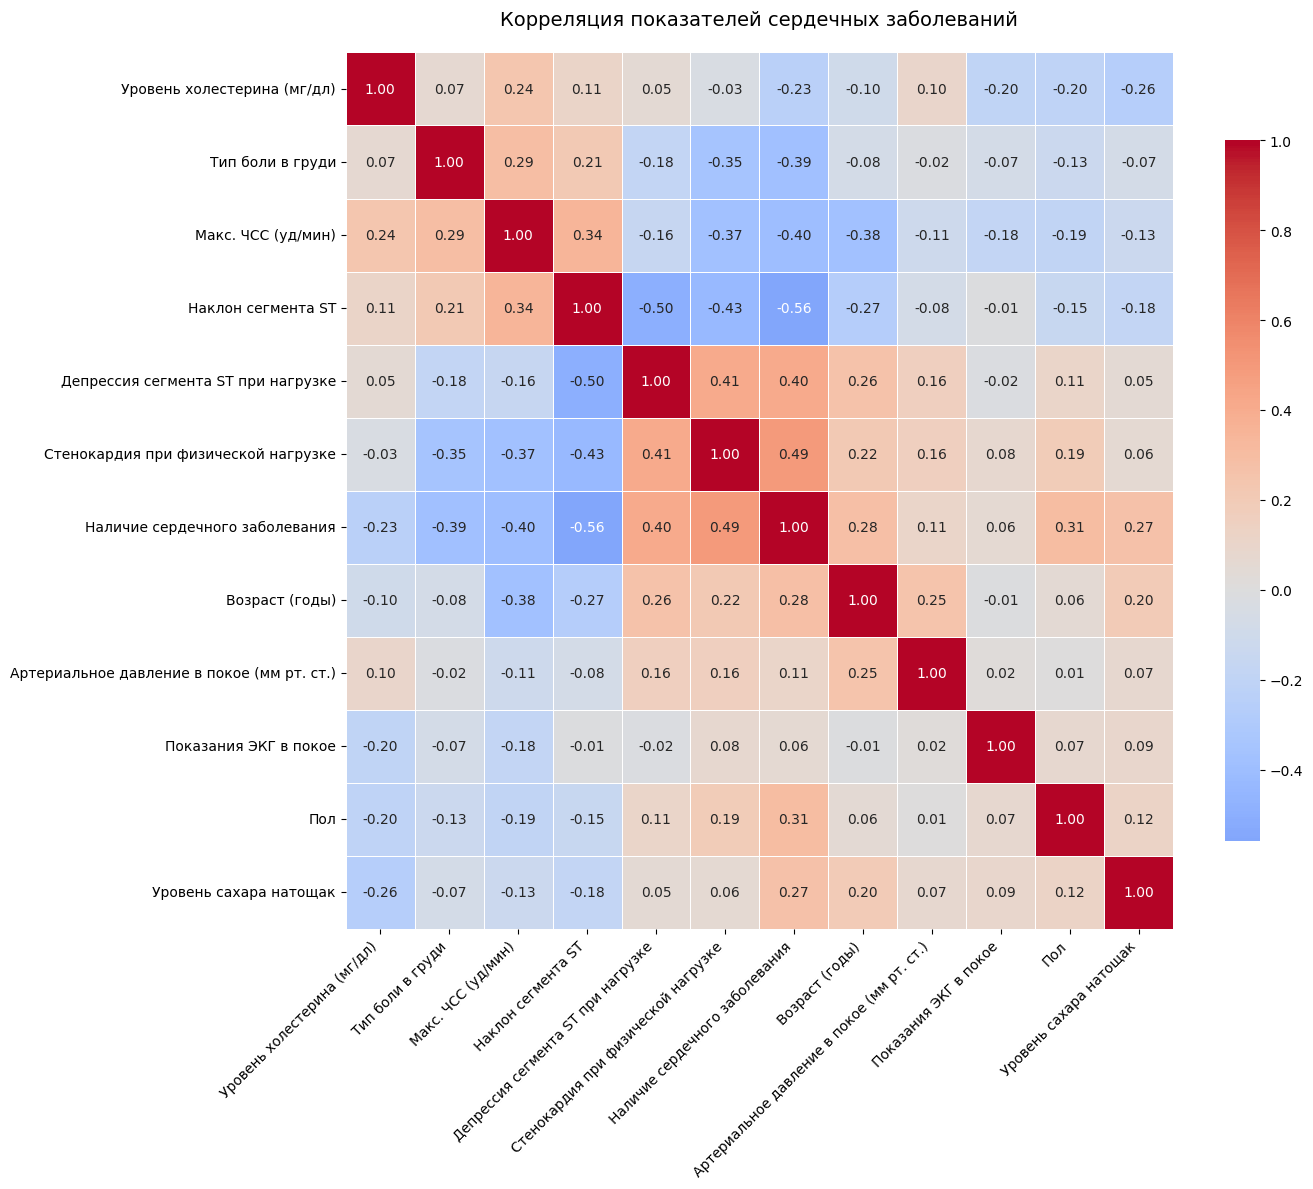

In [33]:
# Кодируем категориальные переменные
df_encoded = df.copy()
for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Выбираем все колонки для анализа
numeric_cols = list(russian_labels.keys())
data = df_encoded[numeric_cols].dropna()

# Вычисляем корреляцию
corr = data.corr(method='pearson')

# Переименовываем колонки для визуализации
corr.index = [russian_labels[col] for col in corr.index]
corr.columns = [russian_labels[col] for col in corr.columns]

# Построение тепловой карты без дендрограмм
plt.figure(figsize=(14, 12))
ax = sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'location': 'right', 'shrink': 0.8}  # Цветовая шкала справа
)

# Настройка отображения
plt.title('Корреляция показателей сердечных заболеваний', pad=20, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Убираем лишние границы
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

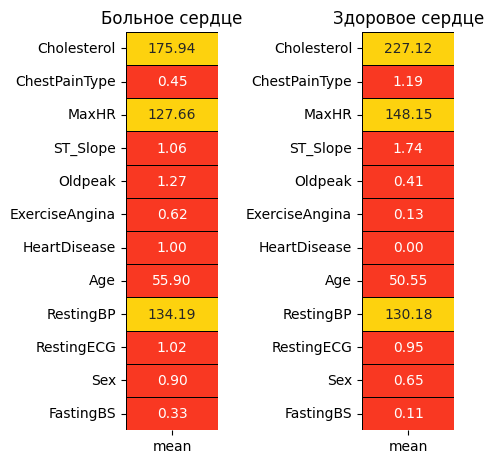

In [51]:
yes = data[data['HeartDisease'] == 1].describe().T
no = data[data['HeartDisease'] == 0].describe().T
colors = ['#F93822','#FDD20E']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Больное сердце');

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Здоровое сердце');

fig.tight_layout(pad = 2)

In [52]:
sex = data[data['HeartDisease'] == 1]['Sex'].value_counts()
sex = [sex[0] / sum(sex) * 100, sex[1] / sum(sex) * 100]

cp = data[data['HeartDisease'] == 1]['ChestPainType'].value_counts()
cp = [cp[0] / sum(cp) * 100,cp[1] / sum(cp) * 100,cp[2] / sum(cp) * 100,cp[3] / sum(cp) * 100]

fbs = data[data['HeartDisease'] == 1]['FastingBS'].value_counts()
fbs = [fbs[0] / sum(fbs) * 100,fbs[1] / sum(fbs) * 100]

restecg = data[data['HeartDisease'] == 1]['RestingECG'].value_counts()
restecg = [restecg[0] / sum(restecg) * 100,restecg[1] / sum(restecg) * 100,restecg[2] / sum(restecg) * 100]

exang = data[data['HeartDisease'] == 1]['ExerciseAngina'].value_counts()
exang = [exang[0] / sum(exang) * 100,exang[1] / sum(exang) * 100]

slope = data[data['HeartDisease'] == 1]['ST_Slope'].value_counts()
slope = [slope[0] / sum(slope) * 100,slope[1] / sum(slope) * 100,slope[2] / sum(slope) * 100]

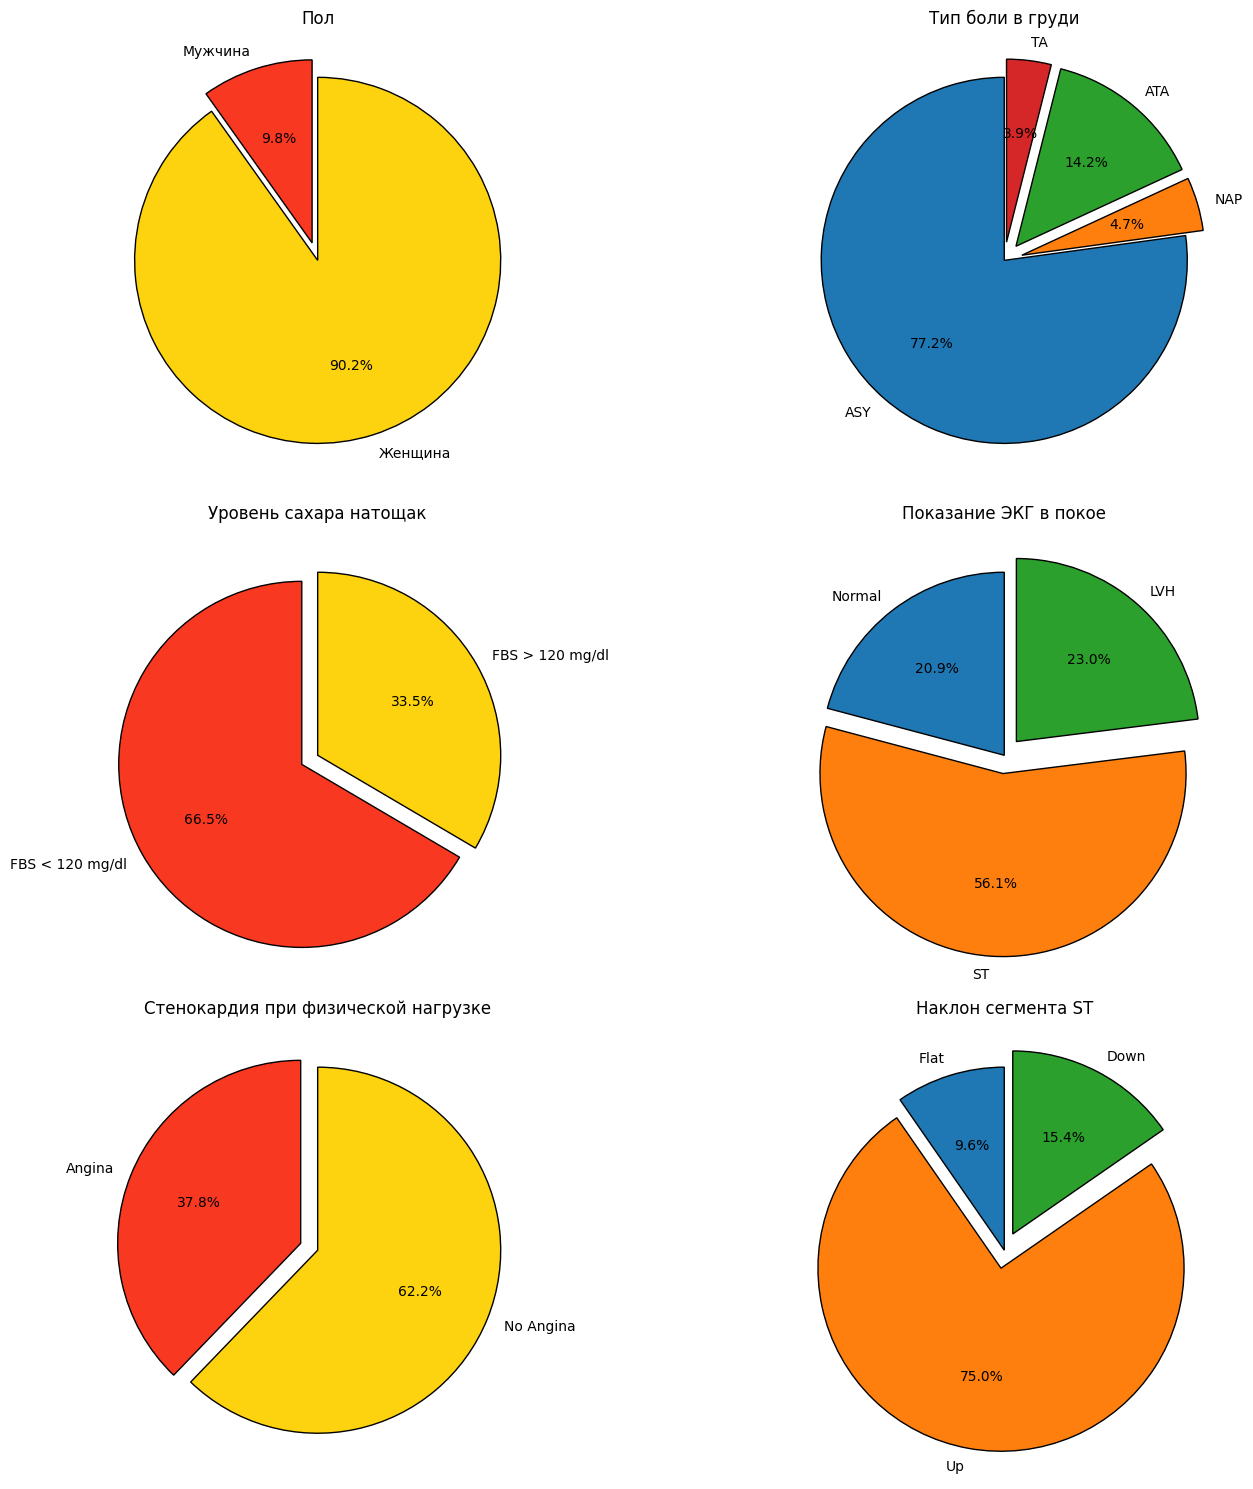

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes[0,0].pie(sex, labels=['Мужчина','Женщина'], autopct='%1.1f%%', startangle=90, 
             explode=(0.1,0), colors=colors, wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[0,0].set_title('Пол')
axes[0,1].pie(cp, labels=['ASY', 'NAP', 'ATA', 'TA'], autopct='%1.1f%%', startangle=90,
             explode=(0,0.1,0.1,0.1), wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[0,1].set_title('Тип боли в груди')
axes[1,0].pie(fbs, labels=['FBS < 120 mg/dl','FBS > 120 mg/dl'], autopct='%1.1f%%',
             startangle=90, explode=(0.1,0), colors=colors, wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[1,0].set_title('Уровень сахара натощак')
axes[1,1].pie(restecg, labels=['Normal','ST','LVH'], autopct='%1.1f%%', startangle=90,
             explode=(0,0.1,0.1), wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[1,1].set_title('Показание ЭКГ в покое')
axes[2,0].pie(exang, labels=['Angina','No Angina'], autopct='%1.1f%%', startangle=90,
             explode=(0.1,0), colors=colors, wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[2,0].set_title('Стенокардия при физической нагрузке')
axes[2,1].pie(slope, labels=['Flat','Up','Down'], autopct='%1.1f%%', startangle=90,
             explode=(0,0.1,0.1), wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[2,1].set_title('Наклон сегмента ST')

plt.tight_layout()
plt.show()

In [60]:
sex = data[data['HeartDisease'] == 0]['Sex'].value_counts()
sex = [sex[0] / sum(sex) * 100, sex[1] / sum(sex) * 100]

cp = data[data['HeartDisease'] == 0]['ChestPainType'].value_counts()
cp = [cp[0] / sum(cp) * 100,cp[1] / sum(cp) * 100,cp[2] / sum(cp) * 100,cp[3] / sum(cp) * 100]

fbs = data[data['HeartDisease'] == 0]['FastingBS'].value_counts()
fbs = [fbs[0] / sum(fbs) * 100,fbs[1] / sum(fbs) * 100]

restecg = data[data['HeartDisease'] == 0]['RestingECG'].value_counts()
restecg = [restecg[0] / sum(restecg) * 100,restecg[1] / sum(restecg) * 100,restecg[2] / sum(restecg) * 100]

exang = data[data['HeartDisease'] == 0]['ExerciseAngina'].value_counts()
exang = [exang[0] / sum(exang) * 100,exang[1] / sum(exang) * 100]

slope = data[data['HeartDisease'] == 0]['ST_Slope'].value_counts()
slope = [slope[0] / sum(slope) * 100,slope[1] / sum(slope) * 100,slope[2] / sum(slope) * 100]

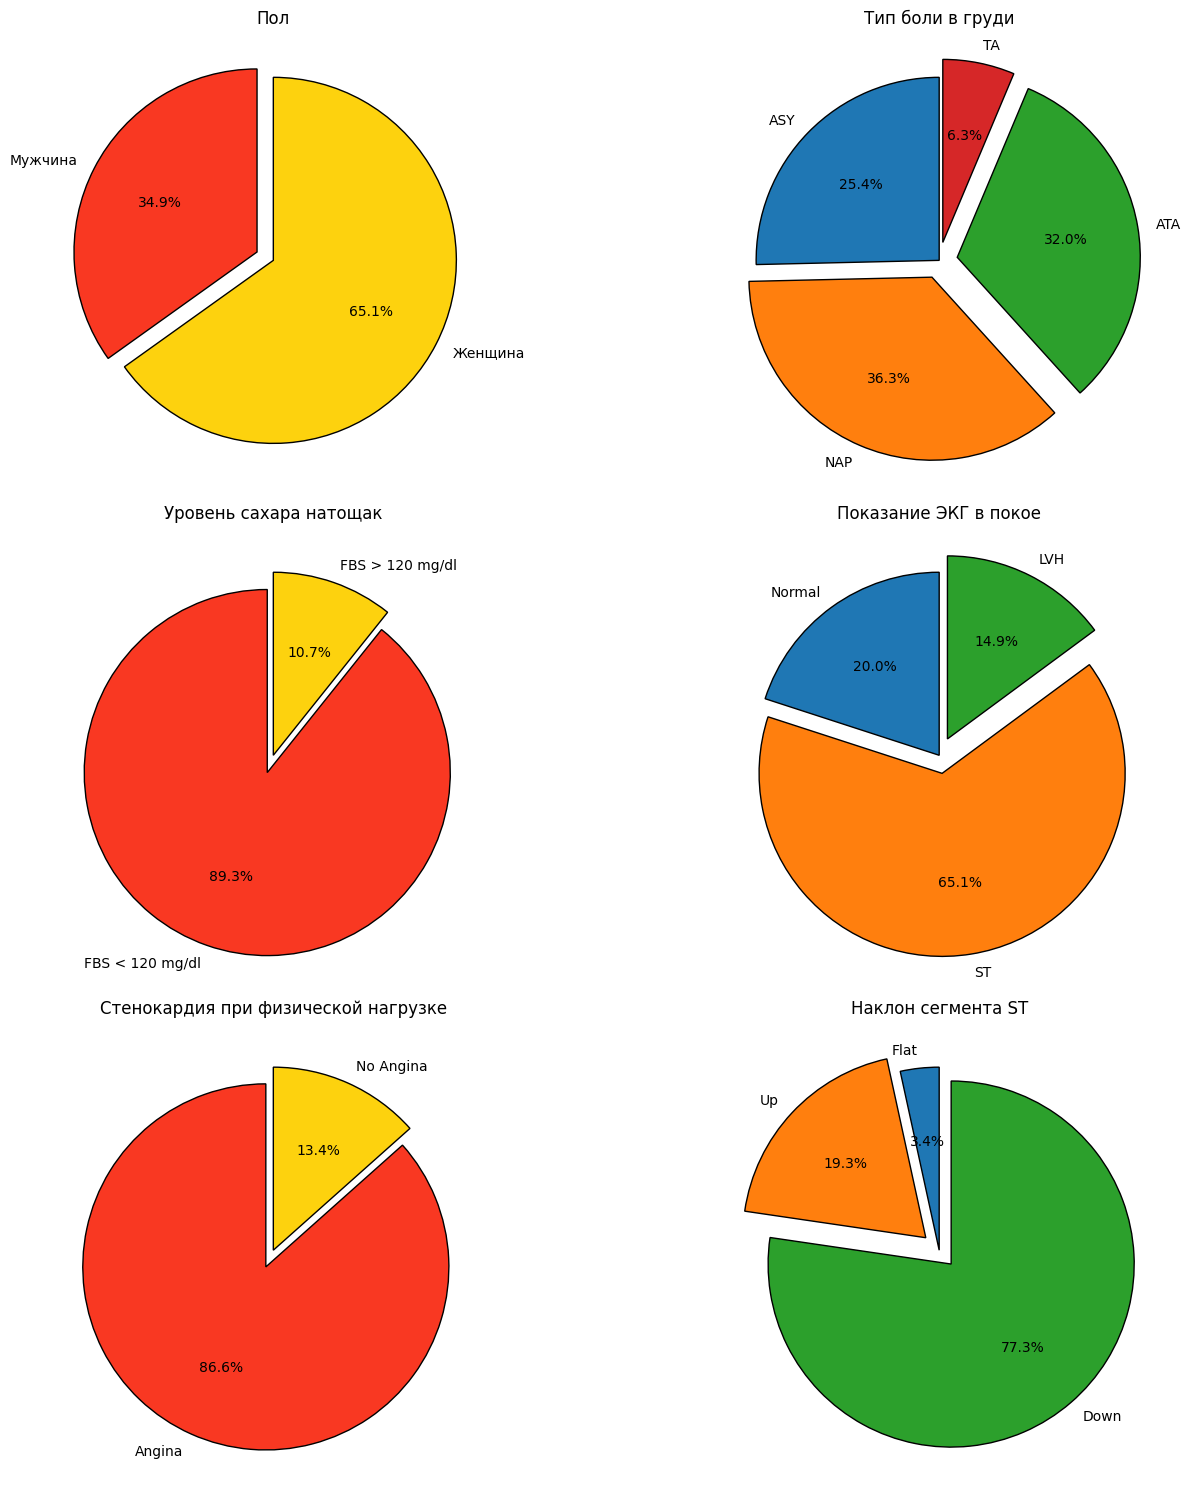

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes[0,0].pie(sex, labels=['Мужчина','Женщина'], autopct='%1.1f%%', startangle=90, 
             explode=(0.1,0), colors=colors, wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[0,0].set_title('Пол')
axes[0,1].pie(cp, labels=['ASY', 'NAP', 'ATA', 'TA'], autopct='%1.1f%%', startangle=90,
             explode=(0,0.1,0.1,0.1), wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[0,1].set_title('Тип боли в груди')
axes[1,0].pie(fbs, labels=['FBS < 120 mg/dl','FBS > 120 mg/dl'], autopct='%1.1f%%',
             startangle=90, explode=(0.1,0), colors=colors, wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[1,0].set_title('Уровень сахара натощак')
axes[1,1].pie(restecg, labels=['Normal','ST','LVH'], autopct='%1.1f%%', startangle=90,
             explode=(0,0.1,0.1), wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[1,1].set_title('Показание ЭКГ в покое')
axes[2,0].pie(exang, labels=['Angina','No Angina'], autopct='%1.1f%%', startangle=90,
             explode=(0.1,0), colors=colors, wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[2,0].set_title('Стенокардия при физической нагрузке')
axes[2,1].pie(slope, labels=['Flat','Up','Down'], autopct='%1.1f%%', startangle=90,
             explode=(0,0.1,0.1), wedgeprops={'edgecolor':'black', 'linewidth':1})
axes[2,1].set_title('Наклон сегмента ST')

plt.tight_layout()
plt.show()

Сердечно-сосудистые заболевания являются одной из основных причин смертности во всем мире. Ранняя и точная диагностика критически важна для своевременного лечения и предотвращения серьезных осложнений. Мы хотим разработать модель, способную с высокой точностью предсказывать наличие сердечно-сосудистых заболеваний на основе показателей пациента.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Разделение на признаки и целевую переменную
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка точности   
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



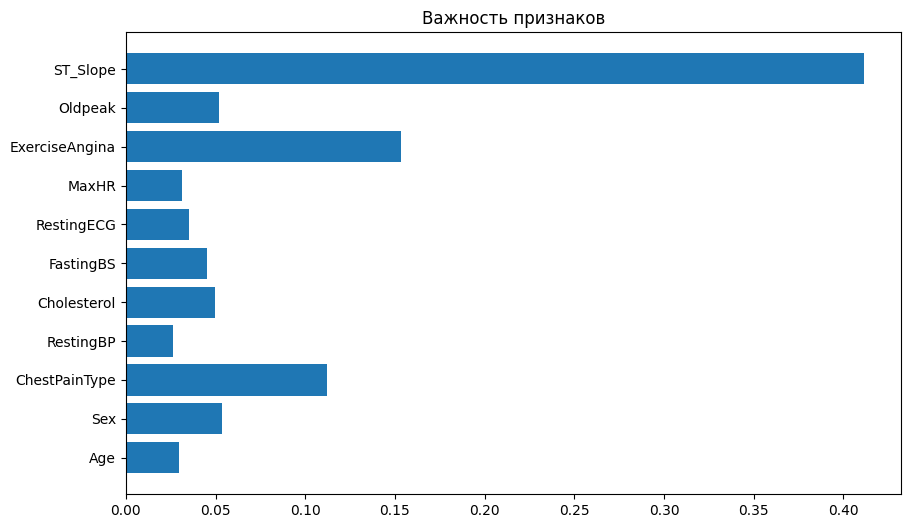

In [65]:
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title('Важность признаков')
plt.show()

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data = pd.get_dummies(data, columns=["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"])

# Разделяем на признаки (X) и целевую переменную (y)
X = data.drop("HeartDisease", axis=1)
y = data["HeartDisease"]

# Масштабируем числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Точность модели: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Точность модели: 0.85
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



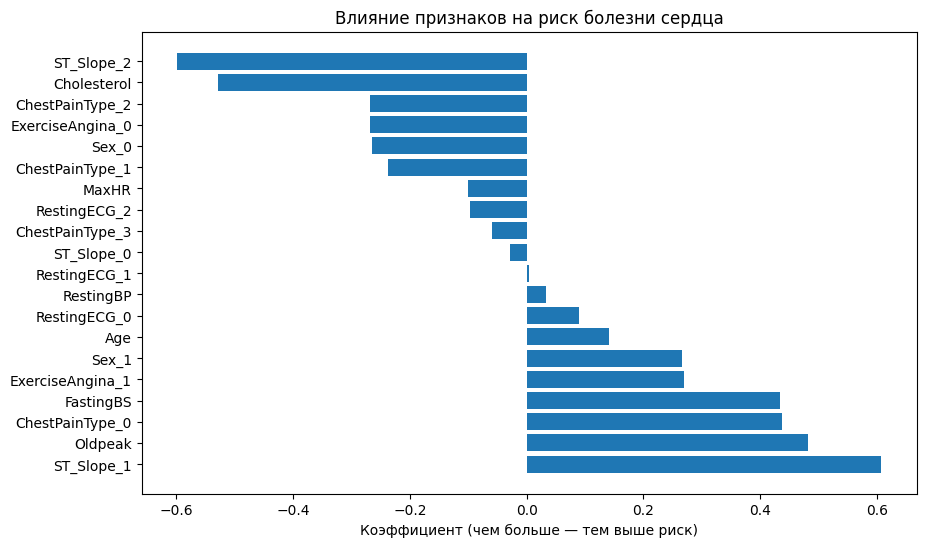

In [ ]:
importance = pd.DataFrame({
    "Признак": X.columns,
    "Важность": model.coef_[0]
}).sort_values("Важность", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance["Признак"], importance["Важность"])
plt.title("Влияние признаков на риск болезни сердца")
plt.xlabel("Коэффициент (чем больше — тем выше риск)")
plt.show()

In [85]:
features = df1[df1.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 2)

In [88]:
def model(classifier):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

def model_evaluation(classifier):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

In [89]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
model(classifier_dt)

Accuracy :  84.78%
Cross Validation Score :  89.09%
ROC_AUC Score :  84.62%
